<a href="https://colab.research.google.com/github/yqz5514/Reg-Stats-Coding-Project/blob/main/Cumulative_Economically_Significant_Final_Rules_by_Administration_demo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download files

In [1]:
install.packages("R.utils")
library("R.utils")
# runtime: within 1 min

install.packages('png') # use for load png file
install.packages('showtext') #directly works on .OTF fonts, for custom font on ggplot
install.packages('ggpattern') # for plot pattern
install.packages('ggrepel') # legend
install.packages('gcookbook')
# load packages
library(ggplot2)
library(showtext)
library(png)
library(ggpattern)
library(tidyr)
library(ggrepel)
library(dplyr)
library(scales)
library(gcookbook)

# Dowloading logo and font style for reg stats plots
download.file("https://raw.githubusercontent.com/yqz5514/Reg-Stats-Coding-Project/main/gw_ci_rsc_2cs_pos.png",
              "gw_ci_rsc_2cs_pos.png.gz")
download.file("https://github.com/yqz5514/Reg-Stats-Coding-Project/raw/main/a-avenir-next-lt-pro.otf",
              "a-avenir-next-lt-pro.otf.gz")
gunzip('gw_ci_rsc_2cs_pos.png.gz')
gunzip('a-avenir-next-lt-pro.otf.gz')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Warning message in install.packages("R.utils"):
“installation of package ‘R.utils’ had non-zero exit status”


ERROR: ignored

In [ ]:
# download ES rules published data
download.file("https://raw.githubusercontent.com/yqz5514/Reg-Stats-Coding-Project/main/data/Cumulative_ES_rules_published_months_in_office_071023.csv",
              "Cumulative_ES_rules_published_months_in_office_071023.csv.gz")
gunzip('Cumulative_ES_rules_published_months_in_office_071023.csv.gz')


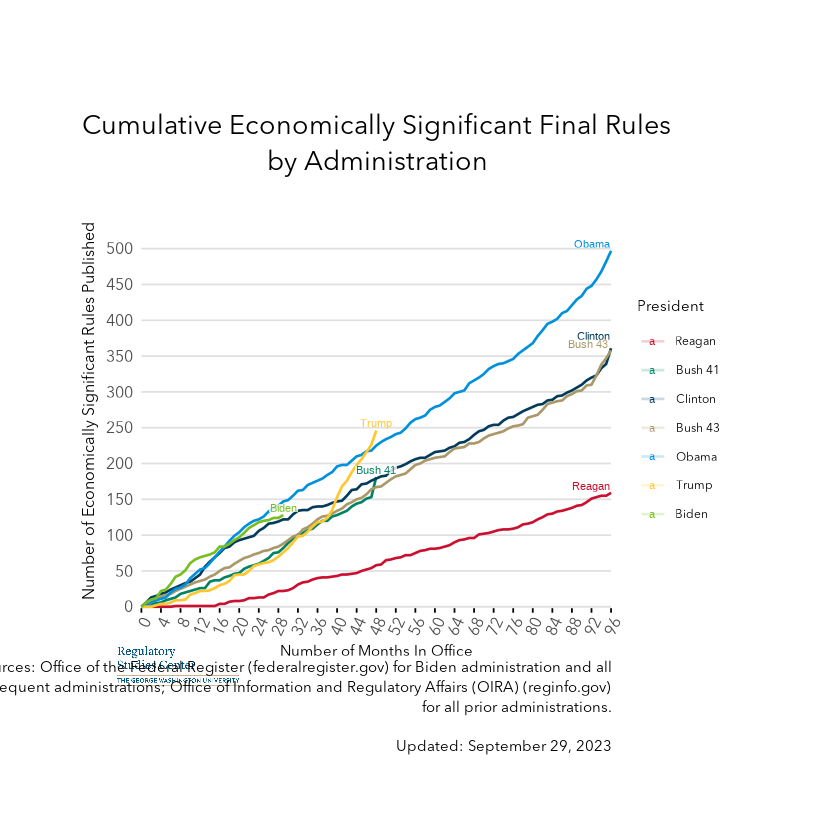

In [ ]:
# Cumulative Economically Significant Final Rules by Administration

linetheme <- theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, vjust=-2, margin = margin(b = 40, unit = "pt"), size=20),
    axis.text.x = element_text(angle = 65, hjust = 1, vjust = 1,size=12),
    legend.position = "right",
    panel.grid.major.x = element_blank(),
    axis.text.y = element_text(size=12),
    axis.title.y = element_text(size = 12, angle = 90, vjust = 1),
    panel.grid.major.y = element_line(color = "#E0E0E0", linetype = "solid"),
    panel.grid.minor = element_blank(),
    text =element_text(family = "avenir_lt_pro"),
    plot.caption = element_text(hjust = 1, margin = margin(t = 0, l = 6, unit = "pt"),size=11),
    plot.margin = margin(50, 50, 50, 50),
    axis.ticks.x = element_line()
  )
#logo
get_png <- function(filename) {
  grid::rasterGrob(png::readPNG(filename),interpolate = TRUE)
}

l <- get_png("gw_ci_rsc_2cs_pos.png")

#annotation
current_date <- format(Sys.Date(), "%B %d, %Y")
caption_text <- paste("Sources: Office of the Federal Register (federalregister.gov) for Biden administration and all subsequent administrations;\n       Office of Information and Regulatory Affairs (OIRA) (reginfo.gov) for all prior administrations.\n\nUpdated:", current_date)
wrapped_caption <- paste(strwrap(caption_text, width = 95), collapse = "\n")

#font
font_add("avenir_lt_pro","a-avenir-next-lt-pro.otf")
showtext_auto()

# load data
cum_sig <- read.csv("/content/Cumulative_ES_rules_published_months_in_office_071023.csv")


# rename columns (will need to manually update with the names of new presidents)
colnames(cum_sig) <- c("month", "months_in_office", "Reagan", "Bush_41", "Clinton", "Bush_43", "Obama", "Trump", "Biden")

# get rid of unnecessary columns (will also need to manually update with new president names here)
cum_sig <- cum_sig[ , c("months_in_office", "Reagan", "Bush_41", "Clinton", "Bush_43", "Obama", "Trump", "Biden")]

#check the dataframe
# clean the data, remove unnecessary rows (this would need to be altered if a president served more than two terms)
cum_sig <- cum_sig[c(2:98), ]

# create long data frame (will also need to manually add new president's names here)
cum_sig_long_NA <- pivot_longer(cum_sig, cols = c("Reagan", "Bush_41", "Clinton", "Bush_43", "Obama", "Trump", "Biden"), names_to = "president", values_to = "econ_rules")

# convert to num to find and remove null
cum_sig_long_NA$months_in_office<- as.numeric(cum_sig_long_NA$months_in_office)
cum_sig_long_NA$econ_rules <- as.numeric(cum_sig_long_NA$econ_rules)

# remove NA values from long data frame (these NA values are the potential econ_rules values for presidents who didn't/haven't yet served the maximum number of months)
cum_sig_long <- cum_sig_long_NA[complete.cases(cum_sig_long_NA), ] # data frame need clean
#sum(is.na(cum_sig_long))

# change president column to factor (assign levels and labels)
cum_sig_long <- cum_sig_long %>%
  mutate(president = factor(president,
                        levels = c("Reagan",
                                   "Bush_41",
                                   "Clinton",
                                   "Bush_43",
                                   "Obama",
                                   "Trump",
                                   "Biden"),
                        labels = c("Reagan",
                                   "Bush 41",
                                   "Clinton",
                                   "Bush 43",
                                   "Obama",
                                   "Trump",
                                   "Biden")))

# calculate the end points of the lines
line_ends <- cum_sig_long %>%
  group_by(president) %>%
  summarise(months_in_office_end = max(months_in_office), econ_rules_end = max(econ_rules))

# set current date
current_date <- format(Sys.Date(), "%B %d, %Y")


# generate line graph
line1 <- ggplot(cum_sig_long, aes(x = months_in_office, y = econ_rules, color = president, group = president)) +
  geom_line(linewidth = 0.75) +
  geom_label_repel(data = line_ends,
                  aes(x = months_in_office_end, y = econ_rules_end, label = president),
                  nudge_x = 0, nudge_y = 10,
                  segment.size = 0.2,
                  size = 3,
                  point.size = 1,
                  box.padding = 0,
                  point.padding = 0,
                  min.segment.length = 0.9,
                  force = 3,
                  label.size = NA,
                  label.padding = 0,
                  label.r = 0,
                  fill = alpha(c("white"), 0.8)) +
  scale_color_manual(values = c("#C9102F",
                                "#008364",
                                "#033C5A",
                                "#AA9868",
                                "#0190DB",
                                "#FFC72C",
                                "#78BE20")) +
  annotation_custom(l, xmin = -5, xmax = 20, ymin = -45, ymax = -120) + # for logo (need to play around with these settings)
  coord_cartesian(clip = "off") +
  xlab("Number of Months In Office") +
  ylab("Number of Economically Significant Rules Published") +
  ggtitle("Cumulative Economically Significant Final Rules \nby Administration") +
  labs(color = "President", caption = wrapped_caption) +
  scale_y_continuous(breaks = seq(0, max(cum_sig_long$econ_rules) + 50, by = 50),
                     expand = c(0, 0),
                     limits = c(-2, max(cum_sig_long$econ_rules) + 50)) +
  scale_x_continuous(breaks = seq(0, max(cum_sig_long$months_in_office), by = 4),
                     expand = c(0, 0),
                     limits = c(0, max(cum_sig_long$months_in_office))) +
  linetheme

line1

# save line1 as pdf
ggsave("line1.pdf", plot = line1, width = 12, height = 9, dpi = 300)